In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
optimizer = tf.keras.optimizers.Adam()

In [3]:
def loss(inputs, outputs):
    return tf.reduce_mean(tf.square(inputs - outputs))

In [4]:
def train_step(model, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        
    grads = t.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return current_loss

In [5]:
class SeriesPredictor(tf.keras.Model):
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        super(SeriesPredictor, self).__init__()
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        
        self.cell = tf.keras.layers.SimpleRNNCell(self.hidden_dim)
        self.rnn = tf.keras.layers.RNN(self.cell)
        self.fc = tf.keras.layers.Dense(self.seq_size)
                
    def call(self, x): 
        x = self.rnn(x)
        x = self.fc(x)
        
        return x


In [6]:
model = SeriesPredictor(input_dim=1, seq_size=5, hidden_dim=100)

In [7]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, 
                          model=model)
manager = tf.train.CheckpointManager(ckpt, '../models/ch16-model2.ckpt', max_to_keep=3)

In [8]:
def train(model, inputs, outputs):
    for i in range(1000):
        err = train_step(model, inputs, outputs)
        ckpt.step.assign_add(1)
        if i % 100 == 0:            
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            print("loss {:1.2f}".format(err.numpy()))
    
    return save_path

In [9]:
def test(model, inputs):
    ckpt.restore(save_path).assert_consumed()
    print("Model restored.")
    outputs = model(inputs)
#    print(outputs.numpy())
    return outputs.numpy()

In [10]:
def load_series(filename, series_idx=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=';') # Loops through the lines of the file and converts to a floating-point number
            next(csvreader) # skip the header
            data = [float(row[series_idx]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
            return normalized_data
    except IOError:
        return None

In [11]:
def split_data(data, percent_train=0.80):
    num_rows = len(data) * percent_train
    return data[:int(num_rows)], data[int(num_rows):]

In [12]:
def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

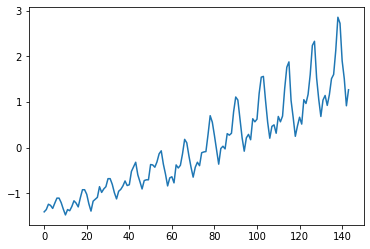

In [13]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim=100)
data = load_series('../data/international-airline-passengers.csv')
plt.figure()
plt.plot(data)
plt.show()

In [14]:
train_data, actual_vals = split_data(data)

In [15]:
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

In [16]:
test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])
    
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

In [17]:
save_path = train(model, train_x, train_y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Saved checkpoint for step 2: ../models/ch16-model2.ckpt/ckpt-1
loss 0.82
Saved checkpoint for step 102: ../models/ch16-model2.ckpt/ckpt-2
loss 0.02
Saved checkpoint for step 202: ../models/ch16-model2.ckpt/ckpt-3
loss 0.01
Saved checkpoint for step 302: ../models/ch16-model2.ckpt/ckpt-4
loss 0.01
Saved checkpoint for step 402: ../models/ch16-model2.ckpt/ckpt-5
loss 0.01
Saved checkpoint for step 502: ../models/ch16-model2.ckpt/ckpt-6
loss 0.01
Saved checkpoint for step 602: ../models/ch16-model2.ckpt/ck

In [18]:
predicted_vals = test(model, test_x)[:,0]

Model restored.


predicted_vals (23,)
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.
Model restored.


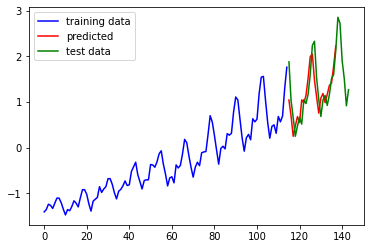

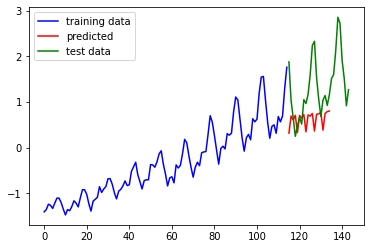

In [19]:
print('predicted_vals', np.shape(predicted_vals))
plot_results(train_data, predicted_vals, actual_vals, '../data/cache/predictions.png')

prev_seq = train_x[-1]
predicted_vals = []
for i in range(20):
    next_seq = test(model, np.asarray([prev_seq]))[:,0]
    predicted_vals.append(next_seq[-1])
    prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))
plot_results(train_data, predicted_vals, actual_vals, '../data/cache/hallucinations.png')